In [1]:
import json
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable

import matplotlib
import pandas as pd


@dataclass
class Stats:
    file: Path
    name_prefix: str | None


@dataclass
class Results:
    insert_df: pd.DataFrame
    search_df: pd.DataFrame


def load_results(stats: Iterable[Stats]) -> Results:
    insert_stats = {}
    search_stats = {}

    for st in stats:
        with open(st.file) as f:
            stats = json.load(f)
            name = st.name_prefix + stats["name"] if st.name_prefix else stats["name"]
            insert_stats |= {f"{name}-{k}": v for k, v in stats["insert_stats"].items()}
            search_stats |= {f"{name}-{k}": v for k, v in stats["search_stats"].items()}

    insert_df = pd.DataFrame.from_records(insert_stats).T
    search_df = pd.DataFrame.from_records(search_stats).T

    for col in (
        "insert_time",
        "processing_time",
        "total_time",
    ):
        insert_df[col] = to_seconds(insert_df[col])

    for col in (
        "mean_time",
        "min_time",
        "max_time",
        "p95_time",
        "p99_time",
        "std_time",
        "total_time",
    ):
        search_df[col] = to_seconds(search_df[col])

    return Results(insert_df, search_df)


def to_seconds(col: pd.Series) -> pd.Series:
    return pd.to_timedelta(col).apply(lambda t: t.total_seconds())

    

### Annoy vs Qdrant Local

In [2]:
results = load_results(
    stats=[
        Stats(file=file, name_prefix=None)
        for dir in ("annoy_local", "qdrant_local")
        for file in (Path("results") / dir).glob(f"*[!rps].json")
    ]
)

In [12]:
results.insert_df.plot.barh(
    rot=0, figsize=(10, 3), xlabel="seconds", title="Insert and Processing Time"
)


<Axes: title={'center': 'Insert and Processing Time'}, xlabel='seconds'>

<Axes: title={'center': 'Search - Mean precision'}>

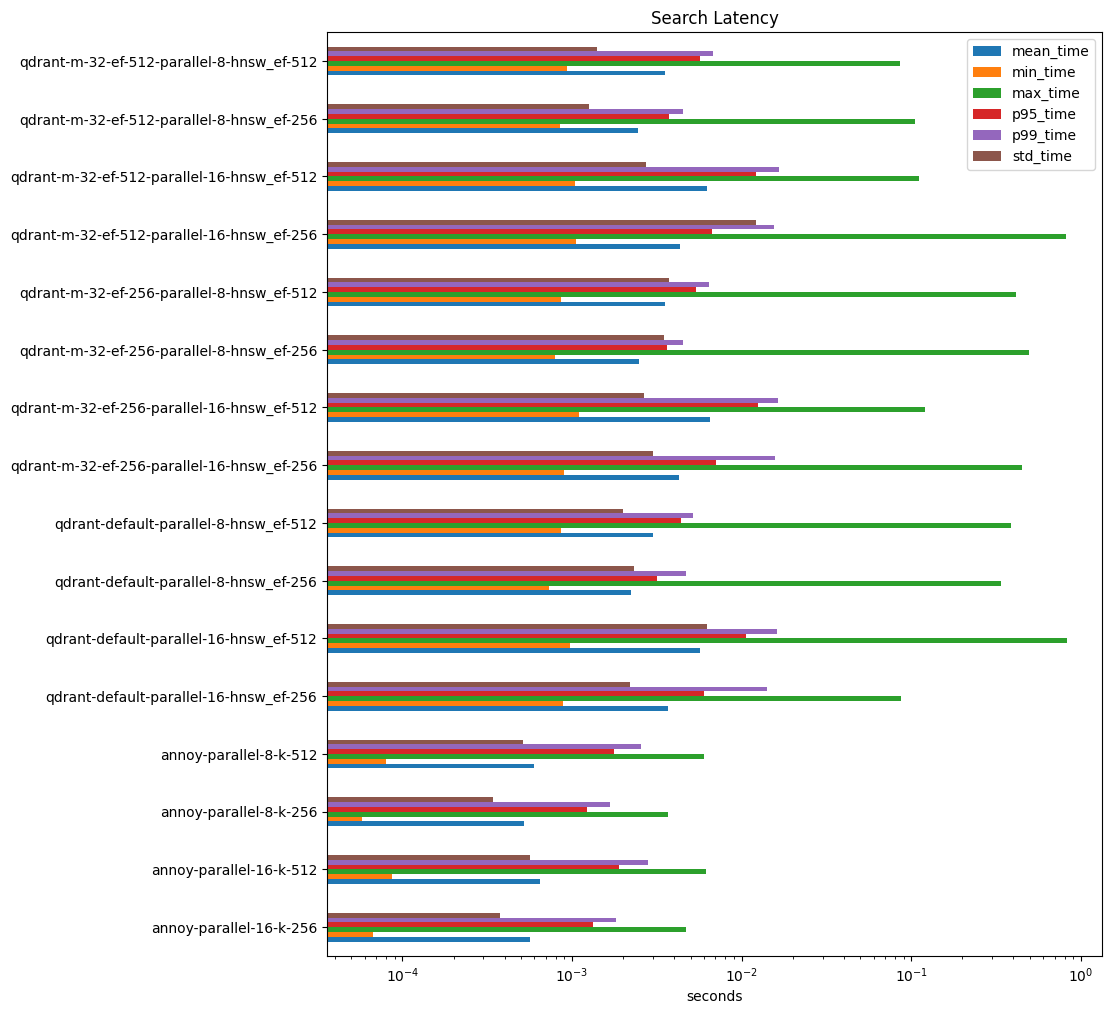

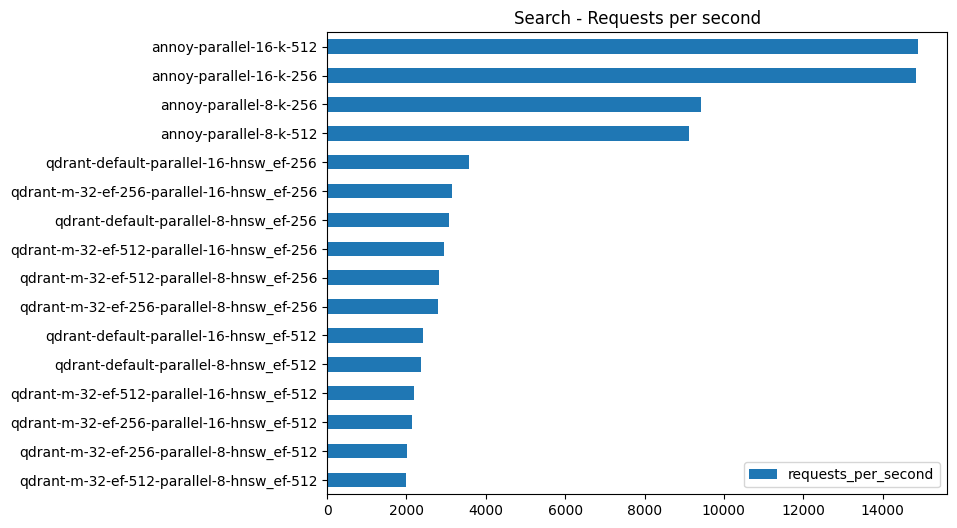

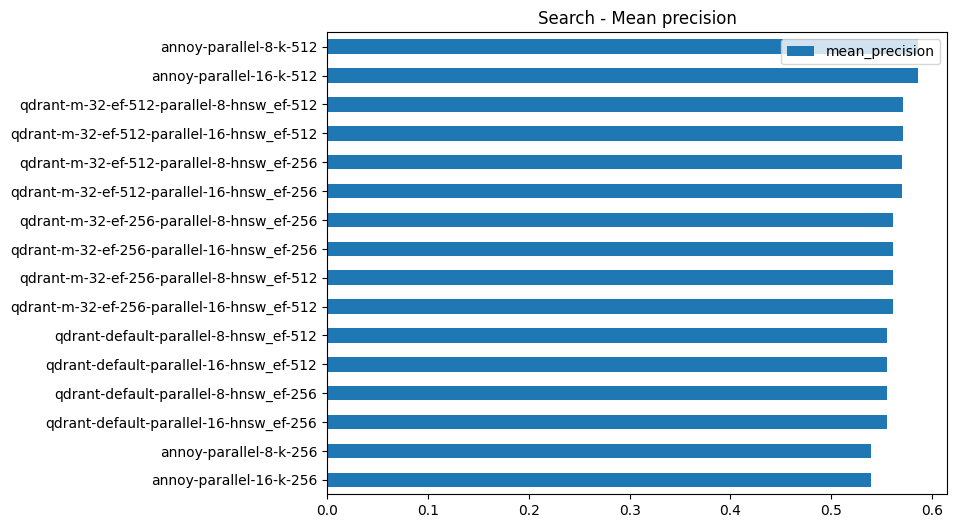

In [28]:
# plot search latencies
results.search_df.drop(
    columns=["mean_precision", "requests_per_second", "total_time"]
).plot.barh(
    rot=0, logx=True, figsize=(10, 12), xlabel="seconds", title="Search Latency"
)

# plot search qps
results.search_df[["requests_per_second"]].sort_values(by="requests_per_second").plot.barh(
    rot=0, figsize=(8, 6), title="Search - Requests per second"
)

# plot mean search precision
results.search_df[["mean_precision"]].sort_values(by="mean_precision").plot.barh(
    rot=0, figsize=(8, 6), title="Search - Mean precision"
)
    

### Qdrant local vs Qdrant Skein

In [19]:
results = load_results(
    stats=[
        Stats(file=file, name_prefix="local-" if "local" in file.parent.name else None)
        for file in Path("results").glob("qdrant*/*[!rps].json")
    ]
)

In [18]:
# Sort insert results to place corresponding 
# local and remote results next to each other in plots.
insert_df = results.insert_df.copy()
local_insert_results = insert_df.index.str.startswith("local")
insert_df.index = insert_df.index.where(
    ~local_insert_results,
    insert_df.index.astype("str") + "_1",
)
results.insert_df = results.insert_df.iloc[
    insert_df.index.str.replace("local-", "").argsort()
]

results.insert_df.plot.barh(
    rot=0, figsize=(10, 3), xlabel="seconds", title="Insert and Processing Time"
)

<Axes: title={'center': 'Insert and Processing Time'}, xlabel='seconds'>

<Axes: title={'center': 'Search - Mean precision'}>

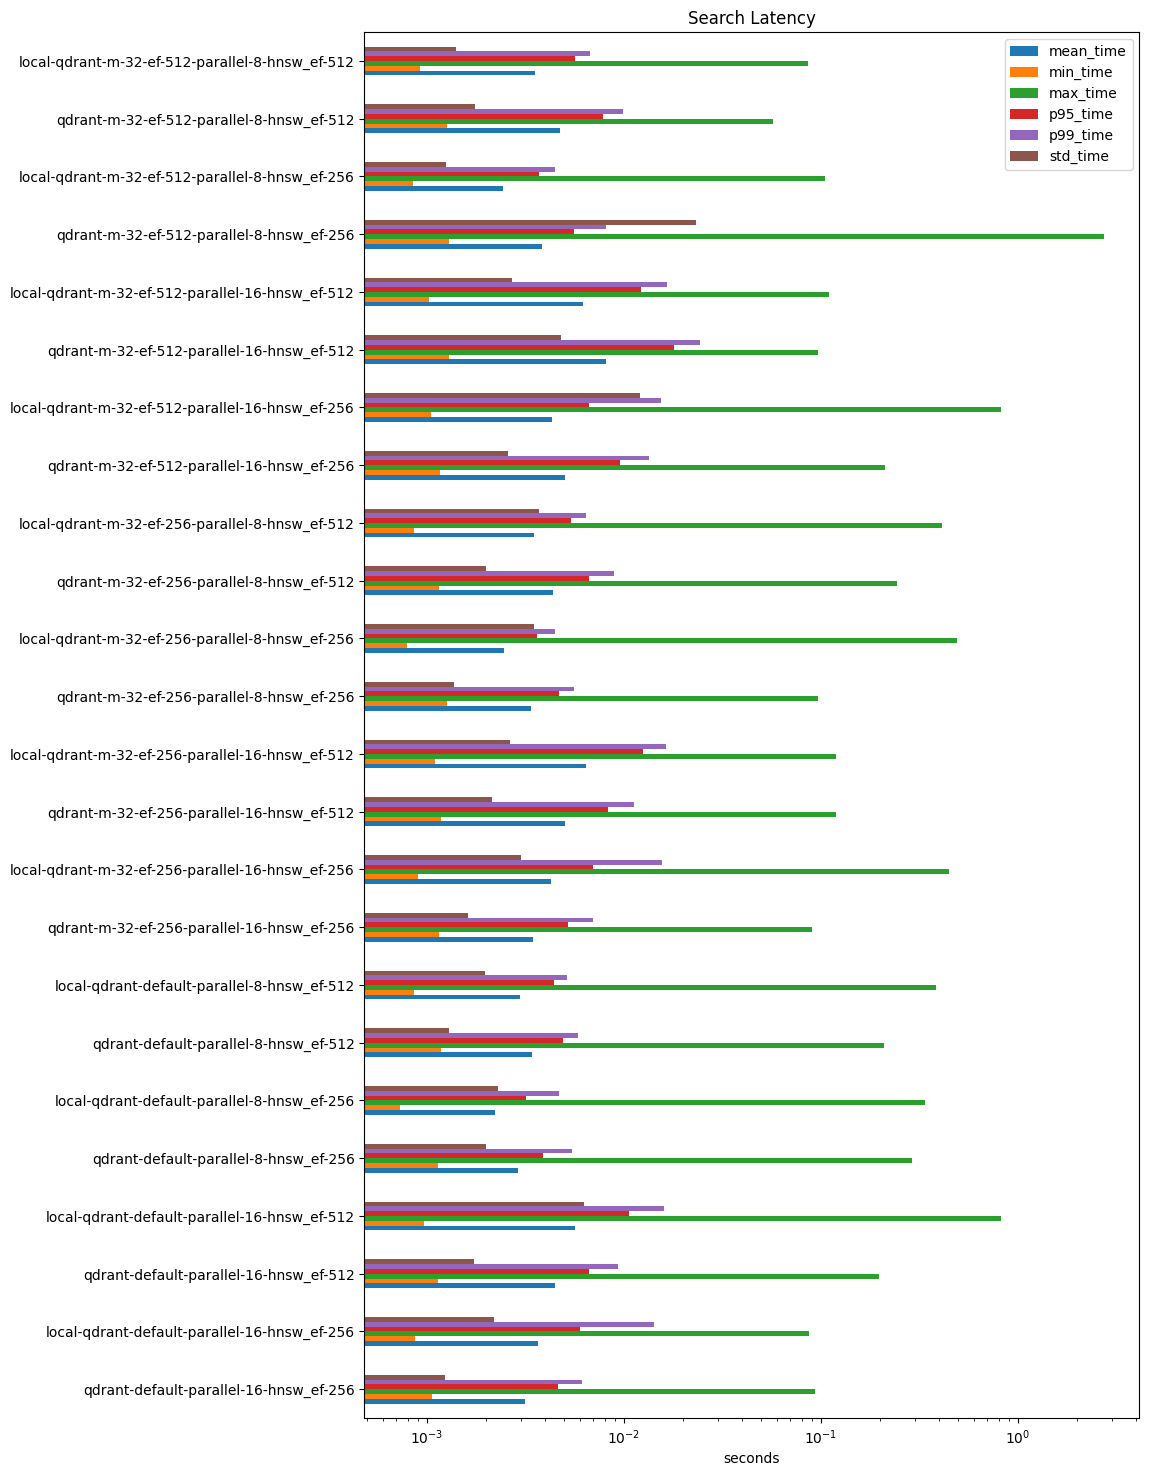

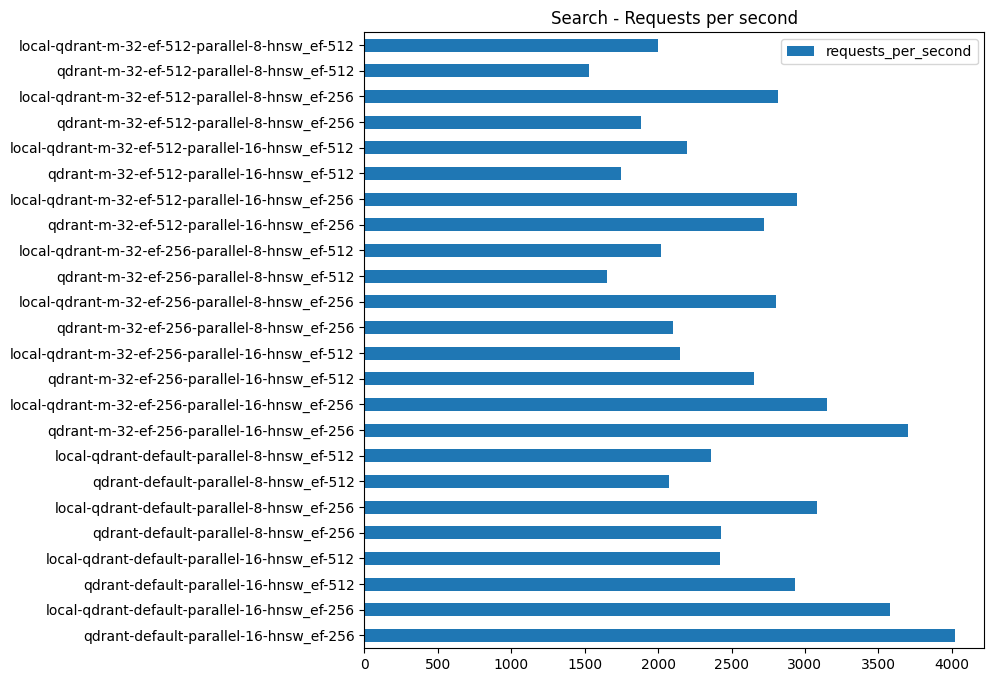

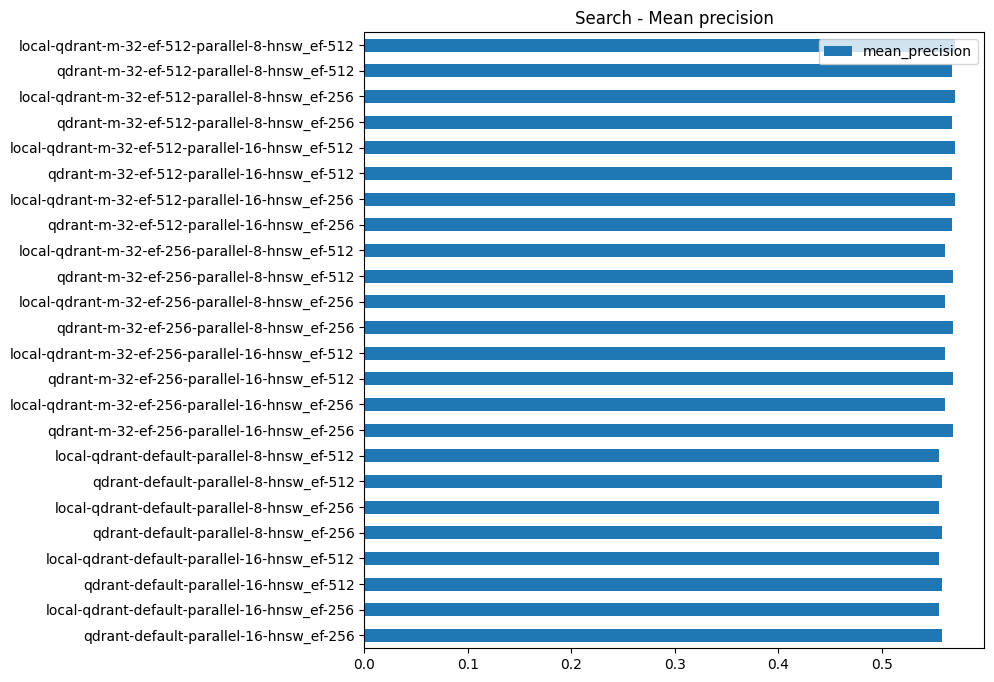

In [53]:
# Sort search results to place corresponding 
# local and remote results next to each other in plots.
search_df = results.search_df.copy()
local_search_results = search_df.index.str.startswith("local")
search_df.index = search_df.index.where(
    ~local_search_results,
    search_df.index.astype("str") + "_1",
)
results.search_df = results.search_df.iloc[
    search_df.index.str.replace("local-", "").argsort()
]

# plot search latency
results.search_df.drop(
    columns=["mean_precision", "requests_per_second", "total_time"]
).plot.barh(
    rot=0, logx=True, figsize=(10, 18), xlabel="seconds", title="Search Latency"
)

# plot search qps
results.search_df[["requests_per_second"]].plot.barh(
    rot=0, figsize=(8, 8), title="Search - Requests per second"
)

# plot mean search precision
results.search_df[["mean_precision"]].plot.barh(
    rot=0, figsize=(8, 8), title="Search - Mean precision"
)


### Requests per second and p95 latency

In [103]:
results = load_results(
    stats=[
        Stats(file=file, name_prefix="local-" if "local" in file.parent.name else None)
        for file in Path("results").glob("qdrant*/*rps.json")
    ]
)

results.search_df["requests_per_second"] = (
    results.search_df["requests_per_second"].astype("float").round()
)


<Axes: title={'center': 'Qdrant Local'}, xlabel='requests_per_second', ylabel='seconds'>

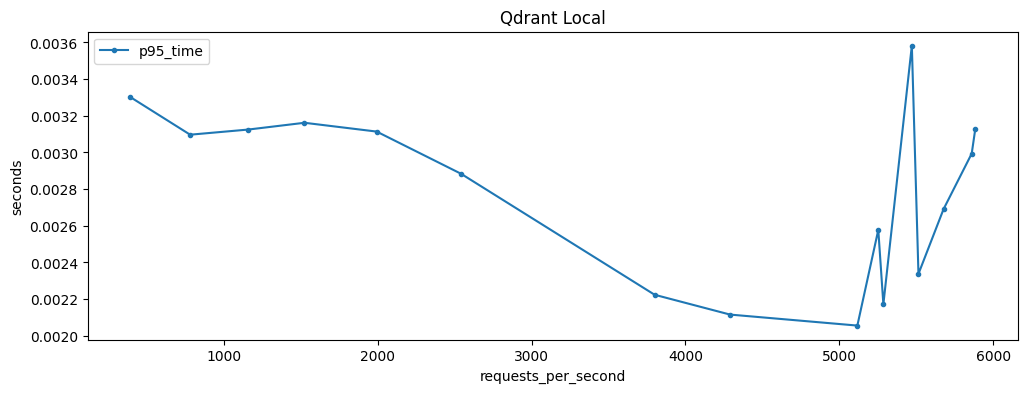

In [109]:
df = results.search_df[results.search_df.index.str.startswith("local")].sort_values(
    by="requests_per_second"
)
df.plot.line(
    x="requests_per_second",
    y="p95_time",
    ylabel="seconds",
    figsize=(12, 4),
    title="Qdrant Local",
    style=".-",
)


<Axes: title={'center': 'Qdrant Skein'}, xlabel='requests_per_second', ylabel='seconds'>

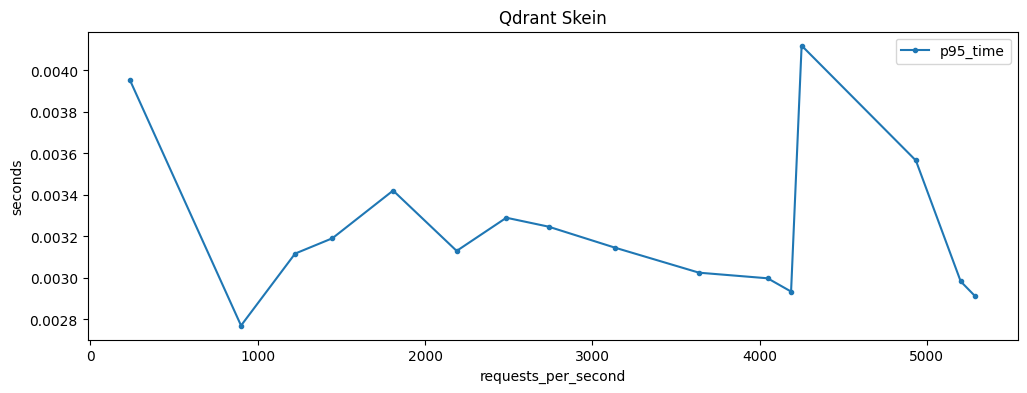

In [110]:
df = results.search_df[~results.search_df.index.str.startswith("local")].sort_values(
    by="requests_per_second"
)
df.plot.line(
    x="requests_per_second",
    y="p95_time",
    ylabel="seconds",
    figsize=(12, 4),
    title="Qdrant Skein",
    style=".-",
)
